# ML Feature enginerring - SelectKbest

In [1]:
%matplotlib inline
%run ../talibref.py
%run ensemble.py
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

### Get data

In [274]:
#df=pd.read_csv("data/IYZ.csv")
ticker = 'IYH'
startdate=datetime.date(2010, 1, 1)
enddate=datetime.date(2015, 12, 1)
df = generate_ticker_data(ticker, startdate, enddate)

Available data: Ticker(IYH) from 2000-06-16 to 2015-12-04
Usable data: Ticker(IYH) from 2001-04-03 to 2015-12-04 
Returned data: Ticker(IYH) from 2010-01-04 to 2015-12-01 
Save path: data/IYH_from_2010-01-04_2015-12-01.csv


In [275]:
dftouse=df.copy()

### Feature Engineering

In [276]:
IGNORE = ['date', 'result_1','close_1','perf_1','result_14','close_14','perf_14','results']

In [277]:
INDICATORS=[]
for v in df.columns:
    l=df[v].unique()
    if len(l) <= 10 and v not in IGNORE:
        #print v, l
        INDICATORS.append(v)

In [278]:
STANDARDIZABLE = []
for v in df.columns:
    if v not in INDICATORS and v not in IGNORE:
        #print v
        STANDARDIZABLE.append(v)

In [279]:
################################################
# Code to add signals from other tickers
################################################

# Additional tickers to consider
moreTickers = [
               '^GSPC', #S&P500
               #'^dji',  #Dow Jones Industrials
               #'^IXIC', #Nasdaq
               'OIL'   #Oil price ETF
              ]

# Signals for additional tickers
STANDARDIZABLE_TO_ADD = ['roc','stoch_slowk']
INDICATORS_TO_ADD = ['cci_signal']


def addDataFromOtherTicker(tickerPlus):
    dfPlus = generate_ticker_data(tickerPlus, startdate, enddate)
    if df.shape == dfPlus.shape:
        dfPluss = dfPlus.copy()
        dfPluss = dfPluss[STANDARDIZABLE_TO_ADD+INDICATORS_TO_ADD]
        STANDARDIZABLE2 = STANDARDIZABLE_TO_ADD[:]
        INDICATORS2 = INDICATORS_TO_ADD[:]
        for p in STANDARDIZABLE2:
            renamed = p+'_'+tickerPlus
            dftouse[renamed]=dfPluss[p]*1.0
            STANDARDIZABLE.append(renamed)
        for p in INDICATORS2:
            renamed = p+'_'+tickerPlus
            dftouse[renamed]=dfPluss[p]
            INDICATORS.append(renamed)
    else:
        print "Data for additional tickers doesn't match data frame for sector of interest."

for tick in moreTickers:
    print "####### Loading data for "+tick+"...."
    addDataFromOtherTicker(tick)    
    time.sleep(0.5)
    
dftouse.head()

####### Loading data for ^GSPC....
Available data: Ticker(^GSPC) from 1950-01-03 to 2015-12-04
Usable data: Ticker(^GSPC) from 1962-05-28 to 2015-12-04 
Returned data: Ticker(^GSPC) from 2010-01-04 to 2015-12-01 
Save path: data/^GSPC_from_2010-01-04_2015-12-01.csv
####### Loading data for OIL....
Available data: Ticker(OIL) from 2006-08-16 to 2015-12-04
Usable data: Ticker(OIL) from 2007-06-05 to 2015-12-04 
Returned data: Ticker(OIL) from 2010-01-04 to 2015-12-01 
Save path: data/OIL_from_2010-01-04_2015-12-01.csv


,date,open,high,low,close,volume,close_1,result_1,perf_1,close_14,result_14,perf_14,results,bb_upper,bb_middle,bb_lower,bb_pct,bb_bandwidth,bb_squeeze,bb_signalup,bb_signaldn,bb_signal,ema50,ema150,ema200,ema_signal1,ema_signal2,kama50,kama150,kama200,kama_signal1,kama_signal2,sar,sar_signal,adx,plus_di,minus_di,adx_trend,adx_direction,adx_signal,aroon_osc,aroon_signal,cci,cci_signal,macd,macd_sigline,macd_hist,macd_signal,ppo,ppo_signal,mfi,mfi_signal,roc,roc_signal,rsi,rsi_signal,ult_osc,ult_signal,willr,wr_signal,ad_osc,ad_signal,stoch_slowk,stoch_slowd,sslow_signal,stoch_fastk,stoch_fastd,srsi_signal,trix,trix_signal,sr_pivotpts,sr_res1,sr_sup1,sr_res2,sr_sup2,sr_res3,sr_sup3,cv_signal,roc_^GSPC,stoch_slowk_^GSPC,cci_signal_^GSPC,roc_OIL,stoch_slowk_OIL,cci_signal_OIL
0,2010-01-04,64.379997,64.680000,64.089996,64.680000,79300,64.320000,False,-0.005566,64.769997,True,0.001391,1,65.203721,63.919501,62.635281,0.796094,4.018241,False,False,False,1,62.364062,59.063805,58.331463,1,1,62.307757,61.827075,60.400792,1,1,64.897998,0,14.281127,25.930510,24.102048,False,True,1,84,1,52.254865,0,0.678436,0.769398,-0.090962,0,0.873031,1,66.546569,0,2.035023,0,61.914518,0,52.501689,0,-12.972879,0,-57400.663069,0,38.498502,44.063574,0,59.555824,19.851941,1,0.159053,1,64.483332,69.366666,64.046666,69.803332,59.163332,74.686666,58.726666,1,3.367458,56.569007,1,11.120401,91.158111,0
1,2010-01-05,64.650002,64.650002,64.129997,64.320000,58400,64.690002,True,0.005753,64.779999,True,0.007152,1,65.220089,63.979501,62.738912,0.637233,3.878081,False,False,False,1,62.440765,59.133424,58.391050,1,1,62.393113,61.902773,60.534505,1,1,64.876438,0,13.522085,24.349717,22.632723,False,True,1,84,1,22.122546,0,0.636285,0.742776,-0.106491,0,0.850439,1,59.783660,0,1.100285,0,57.758765,0,52.322653,0,-32.432359,0,-46084.870982,0,41.212196,36.852237,0,29.048711,29.534845,1,0.159309,1,64.366666,69.133335,63.813335,69.686666,59.046666,74.453335,58.493335,1,3.088524,65.580311,1,10.696517,94.360616,0
2,2010-01-06,64.209999,64.750000,64.209999,64.690002,129300,64.940002,True,0.003865,64.599998,False,-0.001391,1,65.262815,64.061001,62.859187,0.761688,3.752093,False,False,False,1,62.528971,59.207021,58.453726,1,1,62.521417,61.991458,60.661251,1,1,64.855309,0,12.987769,23.996585,21.262200,False,True,1,80,1,57.271762,0,0.625526,0.719326,-0.093800,0,0.893157,1,67.076804,0,0.684828,0,60.679940,0,55.441823,0,-12.432230,0,-5267.343059,0,72.395064,50.701920,0,67.700718,52.101751,1,0.159412,1,64.550000,69.500003,64.180003,69.870000,59.230000,74.820003,58.860003,1,2.072615,95.490211,1,13.871370,96.383747,0
3,2010-01-07,64.529999,64.989998,64.510002,64.940002,43100,65.110001,True,0.002618,64.900002,False,-0.000616,1,65.229961,64.179001,63.128040,0.862050,3.275092,False,False,False,1,62.623521,59.282954,58.518266,1,1,62.692857,62.095297,60.804201,1,1,63.820000,1,12.895538,25.421325,20.097233,False,True,1,76,1,104.204601,0,0.629910,0.701443,-0.071532,0,0.912868,1,67.024542,0,0.355437,0,62.563738,0,57.309344,0,-2.603961,0,22766.419457,1,78.243354,63.950204,0,100.000000,65.583143,0,0.159454,1,64.813334,70.026670,64.636670,70.203334,59.423334,75.416670,59.246670,1,2.117129,96.100927,1,11.928517,90.221762,0
4,2010-01-08,64.949997,65.129997,64.720001,65.110001,44600,65.449997,True,0.005222,64.430000,False,-0.010444,1,65.241575,64.289001,63.336426,0.930938,2.963413,False,False,False,1,62.721030,59.360134,58.583856,1,1,62.861084,62.203855,60.948826,1,1,63.843400,1,13.039679,25.839972,19.132930,False,True,1,80,1,150.378362,0,0.639728,0.689100,-0.049372,0,0.910228,1,71.156423,0,1.149601,0,63.832639,0,62.724882,0,-1.063619,0,44971.795900,1,95.784247,82.140888,0,100.000000,89.233573,0,0.159475,1,64.986666,70.373335,64.843336,70.516665,59.456667,75.903334,59.313337,1,2.176533,95.794862,1,8.644949,83.315586,0


In [280]:
dftouse['date'] = pd.to_datetime(dftouse['date'])
mask = (dftouse.date < '2015-01-01').values
mask.shape, mask.sum()

((1489,), 1258)

#### 1.2 Standardize the data

Use the mask to compute the training and test parts of the dataframe. Use `StandardScaler` from `sklearn.preprocessing` to "fit" the columns in `STANDARDIZABLE` on the training set. Then use the resultant estimator to transform both the training and the test parts of each of the columns in the dataframe, replacing the old unstandardized values in the `STANDARDIZABLE` columns of `dftouse` by the new standardized ones.

In [281]:
#your code here
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(dftouse[mask][STANDARDIZABLE])
dftouse[STANDARDIZABLE] = scaler.transform(dftouse[STANDARDIZABLE])
dftouse.head()

,date,open,high,low,close,volume,close_1,result_1,perf_1,close_14,result_14,perf_14,results,bb_upper,bb_middle,bb_lower,bb_pct,bb_bandwidth,bb_squeeze,bb_signalup,bb_signaldn,bb_signal,ema50,ema150,ema200,ema_signal1,ema_signal2,kama50,kama150,kama200,kama_signal1,kama_signal2,sar,sar_signal,adx,plus_di,minus_di,adx_trend,adx_direction,adx_signal,aroon_osc,aroon_signal,cci,cci_signal,macd,macd_sigline,macd_hist,macd_signal,ppo,ppo_signal,mfi,mfi_signal,roc,roc_signal,rsi,rsi_signal,ult_osc,ult_signal,willr,wr_signal,ad_osc,ad_signal,stoch_slowk,stoch_slowd,sslow_signal,stoch_fastk,stoch_fastd,srsi_signal,trix,trix_signal,sr_pivotpts,sr_res1,sr_sup1,sr_res2,sr_sup2,sr_res3,sr_sup3,cv_signal,roc_^GSPC,stoch_slowk_^GSPC,cci_signal_^GSPC,roc_OIL,stoch_slowk_OIL,cci_signal_OIL
0,2010-01-04,-0.969225,-0.970395,-0.965853,-0.958492,-0.194781,64.320000,False,-0.005566,64.769997,True,0.001391,1,-1.001137,-0.981755,-0.958805,0.557309,-0.606613,False,False,False,1,-1.033527,-1.129516,-1.143726,1,1,-1.040937,-1.071155,-1.117714,1,1,-0.914472,0,-1.022470,-0.191594,0.055401,False,True,1,0.900622,1,0.171106,0,0.293012,0.446821,-0.352635,0,0.324385,1,0.527453,0,0.514166,0,0.486074,0,-0.360539,0,0.726004,0,-0.476363,0,-0.831721,-0.672318,0,0.116496,-1.065212,1,1.157872,1,-0.965081,-0.915746,-0.901420,-0.970428,-0.925090,-0.904737,-0.853913,1,1.022709,-0.171535,1,2.097356,1.481709,0
1,2010-01-05,-0.958494,-0.971582,-0.964256,-0.972804,-0.259016,64.690002,True,0.005753,64.779999,True,0.007152,1,-1.000494,-0.979326,-0.954492,0.059913,-0.657380,False,False,False,1,-1.030337,-1.126393,-1.140952,1,1,-1.037387,-1.067909,-1.112000,1,1,-0.915329,0,-1.101382,-0.407181,-0.104057,False,True,1,0.900622,1,-0.117199,0,0.237546,0.408927,-0.412646,0,0.306508,1,0.200366,0,0.156994,0,0.106343,0,-0.377756,0,0.084260,0,-0.433475,0,-0.728376,-0.970285,0,-0.616541,-0.769144,1,1.161078,1,-0.969719,-0.924490,-0.910671,-0.974786,-0.929870,-0.912815,-0.863385,1,0.922154,0.160817,1,2.019937,1.603270,0
2,2010-01-06,-0.975982,-0.967625,-0.961063,-0.958094,-0.041108,64.940002,True,0.003865,64.599998,False,-0.001391,1,-0.998814,-0.976027,-0.949486,0.449584,-0.703014,False,False,False,1,-1.026668,-1.123091,-1.138033,1,1,-1.032049,-1.064106,-1.106583,1,1,-0.916170,0,-1.156930,-0.455341,-0.252792,False,True,1,0.835609,1,0.219107,0,0.223387,0.375550,-0.363603,0,0.340310,1,0.553098,0,-0.001756,0,0.373264,0,-0.077807,0,0.743834,0,-0.278769,0,0.459159,-0.398026,0,0.312204,-0.079128,1,1.162368,1,-0.962431,-0.910749,-0.896134,-0.967937,-0.922358,-0.900122,-0.848501,1,0.555921,1.263944,1,2.599800,1.680065,0
3,2010-01-07,-0.963263,-0.958130,-0.949087,-0.948155,-0.306040,65.110001,True,0.002618,64.900002,False,-0.000616,1,-1.000106,-0.971251,-0.938296,0.763819,-0.875787,False,False,False,1,-1.022736,-1.119684,-1.135027,1,1,-1.024917,-1.059652,-1.100474,1,1,-0.957350,1,-1.166519,-0.261036,-0.379220,False,True,1,0.770596,1,0.668160,0,0.229157,0.350096,-0.277548,0,0.355907,1,0.550570,0,-0.127619,0,0.545396,0,0.101780,0,1.067955,0,-0.172517,1,0.681880,0.149383,0,1.088304,0.333085,0,1.162896,1,-0.951962,-0.891012,-0.878028,-0.955485,-0.914436,-0.879467,-0.832805,1,0.571968,1.286468,1,2.244953,1.446167,0
4,2010-01-08,-0.946570,-0.952591,-0.940704,-0.941396,-0.301430,65.449997,True,0.005222,64.430000,False,-0.010444,1,-0.999649,-0.966798,-0.929622,0.979507,-0.988679,False,False,False,1,-1.018680,-1.116222,-1.131973,1,1,-1.017919,-1.054997,-1.094293,1,1,-0.956419,1,-1.151534,-0.203942,-0.483870,False,True,1,0.835609,1,1.109949,0,0.242076,0.332527,-0.191906,0,0.353818,1,0.750408,0,0.175838,0,0.661342,0,0.622555,0,1.118753,0,-0.088355,1,1.349888,0.901009,0,1.088304,1.056231,0,1.163166,1,-0.945072,-0.878021,-0.869835,-0.943780,-0.913070,-0.862621,-0.830099,1,0.593383,1.275180,1,1.645234,1.184022,0


We create a list `lcols` of the columns we will use in our classifier. This list should not contain the response `RESP`. How many features do we have?

In [282]:
#lcols=list(dftouse.columns)
#lcols.remove(u'results')
lcols=[]
for c in list(dftouse.columns):
    if c not in IGNORE: 
        lcols.append(c)
print len(lcols)

76


### EDA for the data

We create a variable `ccols` which contains all variables not in our indicators list

In [283]:
ccols=[]
for c in lcols:
    if c not in INDICATORS and c not in IGNORE:
        ccols.append(c)
print len(ccols), len(INDICATORS)

48 28


In [284]:
def cv_optimize(clf, parameters, X, y, n_folds, score_func):
    fitmodel = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func, n_jobs=2)
    fitmodel.fit(X, y)
    return fitmodel.best_estimator_

In [285]:
from sklearn.metrics import confusion_matrix
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=7):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        #print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        #print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    #print "############# based on standard predict ################"
    #print "Accuracy on training data: %0.2f" % (training_accuracy)
    #print "Accuracy on test data:     %0.2f" % (test_accuracy)
    #print confusion_matrix(ytest, clf.predict(Xtest))
    #print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [286]:
X=dftouse[lcols].values
y=dftouse['results'].values
Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]  
reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)

In [287]:
print "whole data set", dftouse['results'].mean()
print "training set", dftouse['results'][mask].mean(), "test set", dftouse['results'][~mask].mean()

whole data set 0.451309603761
training set 0.449125596184 test set 0.463203463203


#####our data is not very asymmetric, but we might still want to balance the trainset

### Balancing train set to test set for training, 


In [288]:
jtrain=np.arange(0, ytrain.shape[0])
n_pos=len(jtrain[ytrain==1])
n_neg=len(jtrain[ytrain==0])
print n_pos, n_neg

ineg = np.random.choice(jtrain[ytrain==0], n_pos, replace=False)
alli=np.concatenate((jtrain[ytrain==1], ineg))
Xtrain_new = Xtrain[alli]
ytrain_new = ytrain[alli]
print Xtrain_new.shape, ytrain_new.shape

reuse_split_balanced=dict(Xtrain=Xtrain_new, Xtest=Xtest, ytrain=ytrain_new, ytest=ytest)
#reuse_split=reuse_split_balanced

565 693
(1130, 76) (1130,)


## Test all classifiersres using SelectKbest

In [289]:
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def evaluate(clf):
    clf.fit(Xtrain,ytrain)
    training_accuracy = accuracy_score(ytrain, clf.predict(Xtrain))
    test_accuracy = accuracy_score(ytest, clf.predict(Xtest))
    df_pred = df[~mask].reset_index(drop=True)
    df_pred['pred_result'] = clf.predict(Xtest)
    df_pred['result_baseline'] = np.ones(df_pred.shape[0])
    _,_,ROI_base,baseline_over_time,_ = evaluate_profit(df_pred, startdate, enddate, 10000, 'result_baseline', 'close', True, [1])
    _,_,ROI_long,bal_over_time,_ = evaluate_profit(df_pred, startdate, enddate, 10000, 'pred_result', 'close', True, [1])
    _,_,ROI_lgst,_,signals = evaluate_profit(df_pred, startdate, enddate, 10000, 'pred_result', 'close', True, [1,0])
    return training_accuracy, test_accuracy, ROI_base, ROI_long, ROI_lgst, signals,bal_over_time,baseline_over_time

def print_result(clfpipe):     
    print "Number of features: {0}".format(clfpipe.get_params()['selectk__k'])
    print "Features: {0}".format(np.array(lcols)[clfpipe.named_steps['selectk'].get_support()].tolist())
    r = evaluate(clfpipe)
    print "train accuracy: {0}".format(r[0])
    print "test accuracy: {0}".format(r[1])
    print "ROI baseline: {0}".format(r[2])
    print "ROI long-only: {0}".format(r[3])
    print "ROI long-short: {0}".format(r[4])

In [290]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score


In [291]:
%%time
max_number_featrues = 20
Results={}
scoring_func="accuracy"


print "#############====================== Log Regression =====================#############"
selectk = SelectKBest(score_func=f_regression)
pipeLR = Pipeline([('selectk', selectk), ('LR', LogisticRegression(penalty="l1"))])
pipeLR, _,_,_,_  = do_classify(pipeLR, {"selectk__k":range(1,max_number_featrues+1), 
                                        "LR__C": [1e-3, 1e-2, 1e-1, 1, 1e2],
                                        "LR__random_state": [111]}, 
                               dftouse,lcols, u'results',1, reuse_split=reuse_split,score_func=scoring_func)

print pipeLR.get_params()['LR__C']
print_result(pipeLR)
Results["log_regression"] = evaluate(pipeLR)

#############====================== Log Regression =====================#############
1
Number of features: 13
Features: ['bb_pct', 'plus_di', 'cci', 'roc', 'rsi', 'ult_osc', 'willr', 'stoch_slowk', 'stoch_slowd', 'stoch_fastk', 'stoch_fastd', 'srsi_signal', 'stoch_slowk_^GSPC']
train accuracy: 0.705087440382
test accuracy: 0.670995670996
ROI baseline: 0.0516879241
ROI long-only: 0.0703817061
ROI long-short: 0.0814144847
CPU times: user 11.4 s, sys: 1.38 s, total: 12.8 s
Wall time: 13.8 s


In [292]:
%%time
print "#############====================== RBF SVM ===========================#############"
pipesvm2 = Pipeline([('selectk', selectk), ('svm2', SVC())])
pipesvm2,_,_,_,_  = do_classify(pipesvm2, {"selectk__k":[2,3,4,5,6,7,9,12,18,25], 
                                            "svm2__C": [1e-2,1e-1,1,1e2,1e4,1e5,1e6,1e7, 1e8,1e9], 
                                            "svm2__gamma": [ 1e-7,1e-8, 1e-9, 1e-10],
                                            "svm2__random_state": [111]}, 
                                 dftouse,lcols, u'results',1, reuse_split=reuse_split,score_func=scoring_func)
print pipesvm2.get_params()['svm2__C'], pipesvm2.get_params()['svm2__gamma']
print_result(pipesvm2)
Results["RBF_SVM"] = evaluate(pipesvm2)

#############====================== RBF SVM ===========================#############
100000000.0 1e-08
Number of features: 12
Features: ['bb_pct', 'plus_di', 'cci', 'rsi', 'ult_osc', 'willr', 'stoch_slowk', 'stoch_slowd', 'stoch_fastk', 'stoch_fastd', 'srsi_signal', 'stoch_slowk_^GSPC']
train accuracy: 0.70826709062
test accuracy: 0.69696969697
ROI baseline: 0.0516879241
ROI long-only: 0.1290156955
ROI long-short: 0.2029674571
CPU times: user 46.6 s, sys: 5.94 s, total: 52.5 s
Wall time: 1min 55s


In [293]:
%%time
print "#############====================== Random Forest =====================#############"
pipeRF = Pipeline([('selectk', selectk), ('RF', RandomForestClassifier())])
pipeRF,_,_,_,_  = do_classify(pipeRF, {"selectk__k": [5,6,7,8,9,10],
                                       "RF__max_depth": [3,5,7], 
                                       "RF__n_estimators": [5,10,20],
                                       "RF__max_features": [1,2,3],
                                       "RF__random_state": [111]}, 
                              dftouse, lcols, u'results', 1, reuse_split=reuse_split,score_func=scoring_func)

print pipeRF.get_params()['RF__max_depth'], pipeRF.get_params()['RF__n_estimators'], pipeRF.get_params()['RF__max_features']
print_result(pipeRF)
Results["Random_forest"] = evaluate(pipeRF)

#############====================== Random Forest =====================#############
5 10 1
Number of features: 10
Features: ['bb_pct', 'cci', 'rsi', 'ult_osc', 'willr', 'stoch_slowk', 'stoch_fastk', 'stoch_fastd', 'srsi_signal', 'stoch_slowk_^GSPC']
train accuracy: 0.748807631161
test accuracy: 0.731601731602
ROI baseline: 0.0516879241
ROI long-only: 0.1714549231
ROI long-short: 0.299117917
CPU times: user 19.3 s, sys: 2.34 s, total: 21.6 s
Wall time: 31.6 s


In [294]:
%%time
print "#############====================== Extra Trees= =====================#############"
pipeET = Pipeline([('selectk', selectk), ('ET', ExtraTreesClassifier())])
pipeET, _,_,_,_  = do_classify(pipeET, {"selectk__k": [5,6,7,8,9,10,15],
                                        "ET__max_depth": [1,2,3,5,7,10,15], 
                                        "ET__n_estimators": [3,5,10],
                                        "ET__max_features": [1,2,3],
                                        "ET__random_state": [111]}, 
                               dftouse, lcols, u'results', 1, reuse_split=reuse_split,score_func=scoring_func)
print "ET__max_depth: {0}".format(pipeET.get_params()['ET__max_depth']) 
print "ET__n_estimators: {0}".format(pipeET.get_params()['ET__n_estimators']) 
print "ET__max_features: {0}".format(pipeET.get_params()['ET__max_features']) 
print_result(pipeET)
Results["Extra_Trees"] = evaluate(pipeET)

#############====================== Extra Trees= =====================#############
ET__max_depth: 3
ET__n_estimators: 10
ET__max_features: 2
Number of features: 8
Features: ['bb_pct', 'cci', 'rsi', 'willr', 'stoch_slowk', 'stoch_fastd', 'srsi_signal', 'stoch_slowk_^GSPC']
train accuracy: 0.709856915739
test accuracy: 0.701298701299
ROI baseline: 0.0516879241
ROI long-only: 0.1449617945
ROI long-short: 0.2347806574
CPU times: user 51.6 s, sys: 6.34 s, total: 57.9 s
Wall time: 1min 4s


In [295]:
%%time
print "#############====================== Gaussian NB ==========================#############"
pipeNB = Pipeline([('selectk', selectk), ('NB', GaussianNB())])
pipeNB,_,_,_,_ = do_classify(pipeNB, {"selectk__k":range(1,max_number_featrues+1)}, 
                             dftouse, lcols, u'results',1, reuse_split=reuse_split,score_func=scoring_func)
print_result(pipeNB)
Results["Gaussian_NB"] = evaluate(pipeNB)

#############====================== Gaussian NB ==========================#############
Number of features: 10
Features: ['bb_pct', 'cci', 'rsi', 'ult_osc', 'willr', 'stoch_slowk', 'stoch_fastk', 'stoch_fastd', 'srsi_signal', 'stoch_slowk_^GSPC']
train accuracy: 0.697138314785
test accuracy: 0.748917748918
ROI baseline: 0.0516879241
ROI long-only: 0.2095047499
ROI long-short: 0.3805875423
CPU times: user 2.44 s, sys: 316 ms, total: 2.76 s
Wall time: 2.96 s


In [296]:
#%%time
#print "#############====================== Gradient Boosting ====================#############"
#pipeGB = Pipeline([('selectk', selectk), ('GB', GradientBoostingClassifier())])
#pipeGB, _,_,_,_  = do_classify(pipeGB, {"selectk__k":range(1,max_number_featrues+1), 
#                                        "GB__n_estimators": [5,10,20,40],
#                                        "GB__learning_rate": [0.1,0.5,1.0],
#                                        "GB__random_state": [111]}, 
#                               dftouse,lcols, u'results',1, reuse_split=reuse_split)
#print pipeGB.get_params()['GB__n_estimators'], pipeGB.get_params()['GB__learning_rate']
#print_result(pipeGB)
#Long_ROI_result["Gradient_bossting"] = evaluate(pipeGB)[3]
#Test_set_accuracies["Gradient_bossting"] = evaluate(pipeGB)[1]

In [297]:
print "#############====================== ENSEMBLE ==========================#############"
eclf = EnsembleClassifier(clfs=[pipeLR, pipesvm2, pipeRF, pipeET, pipeNB], voting='hard')
r = evaluate(eclf)
Results["Ensemble"] = r
print "train accuracy: {0}".format(r[0])
print "test accuracy: {0}".format(r[1])
print "ROI baseline: {0}".format(r[2])
print "ROI long-only: {0}".format(r[3])
print "ROI long-short: {0}".format(r[4])

#############====================== ENSEMBLE ==========================#############
train accuracy: 0.713036565978
test accuracy: 0.709956709957
ROI baseline: 0.0516879241
ROI long-only: 0.1292087574
ROI long-short: 0.2029985837


In [298]:
print "---Test accuracy results---"
for key, value in Results.iteritems():
    print key, value[1]

---Test accuracy results---
RBF_SVM 0.69696969697
Extra_Trees 0.701298701299
Gaussian_NB 0.748917748918
log_regression 0.670995670996
Random_forest 0.731601731602
Ensemble 0.709956709957


In [299]:
print "ROI baseline: {0}".format(evaluate(pipeNB)[2])
print "---Long ROI results---"
for key, value in Results.iteritems():
    print key, value[3]

ROI baseline: 0.0516879241
---Long ROI results---
RBF_SVM 0.1290156955
Extra_Trees 0.1449617945
Gaussian_NB 0.2095047499
log_regression 0.0703817061
Random_forest 0.1714549231
Ensemble 0.1292087574


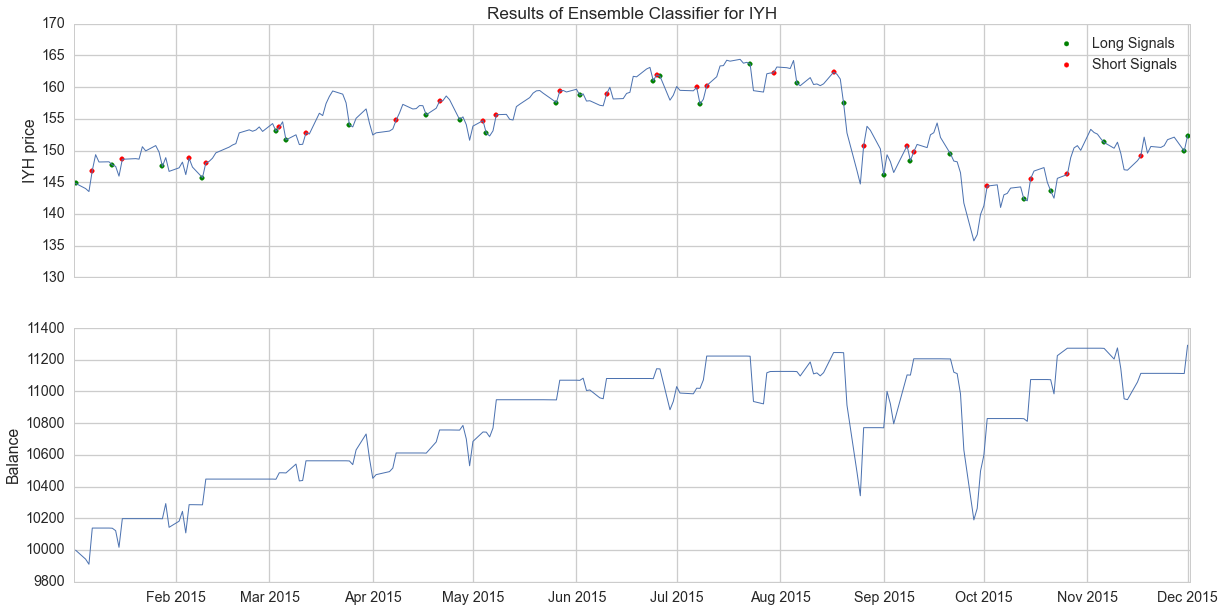

In [300]:
def plot_signal(model, title):
    fig, (ax0,ax1) = plt.subplots(nrows=2, ncols=1, figsize=(20, 10),sharex=True)
    ax0.plot(df.date[~mask], df.close[~mask], lw=1)
    short_days=zip(*evaluate(model)[5][0])[0]
    short_prices=zip(*evaluate(model)[5][0])[1]
    long_days=zip(*evaluate(model)[5][1])[0]
    long_prices=zip(*evaluate(model)[5][1])[1]
    ax0.scatter(long_days, long_prices, color='g', label="Long Signals") 
    ax0.scatter(short_days, short_prices, color='r', label="Short Signals")
    ax0.legend(frameon=False, loc='upper right')
    ax0.set_title(title)
    ax0.set_ylabel(ticker + " price")
    
    ax1.plot(zip(*evaluate(model)[6])[0], zip(*evaluate(model)[6])[1], lw=1)
    ax1.set_ylabel("Balance")
plot_signal(eclf, 'Results of Ensemble Classifier for '+ticker)

In [301]:
Results={}
Results["log_regression"] = evaluate(pipeLR)
Results["RBF_SVM"] = evaluate(pipesvm2)
Results["Random_forest"] = evaluate(pipeRF)
Results["Extra_Trees"] = evaluate(pipeET)
Results["Gaussian_NB"] = evaluate(pipeNB)
Results["Ensemble"] = evaluate(eclf)

Results2=Results

for aModel, value in Results2.iteritems():
    for j in [6,7]:
        i=0
        for item in Results2[aModel][j]:
            aDate = item[0]
            aVal = item[1]
            conv = int(time.mktime(aDate.timetuple()))*1000
            #conv = int(aDate.strftime("%s"))
            Results2[aModel][j][i]=[conv,aVal]
            i=i+1
    #remove signals for now
    Results2[aModel][5][0]=[]
    Results2[aModel][5][1]=[]
Results2

{'Ensemble': (0.71303656597774245,
  0.70995670995671001,
  0.051687924100000053,
  0.1292087574000001,
  0.20299858369999949,
  {0: [], 1: []},
  [[1420174800000, 9999.0],
   [1420434000000, 9942.4195170000003],
   [1420520400000, 9909.9894480000003],
   [1420606800000, 10138.379241000001],
   [1420693200000, 10138.379241000001],
   [1420779600000, 10138.379241000001],
   [1421038800000, 10138.379241000001],
   [1421125200000, 10137.379241000001],
   [1421211600000, 10121.739513],
   [1421298000000, 10017.019989],
   [1421384400000, 10197.899173],
   [1421730000000, 10197.899173],
   [1421816400000, 10197.899173],
   [1421902800000, 10197.899173],
   [1421989200000, 10197.899173],
   [1422248400000, 10197.899173],
   [1422334800000, 10197.899173],
   [1422421200000, 10196.899173],
   [1422507600000, 10292.809173000001],
   [1422594000000, 10143.079311],
   [1422853200000, 10181.719104],
   [1422939600000, 10243.81869],
   [1423026000000, 10107.888621],
   [1423112400000, 10285.908759]

In [302]:
# Save results for this ticker to a JSON file
import json
fd = open("../ML_results/"+ticker+".json","w")
json.dump(Results2, fd)
fd.close()

# Save time series
for aModel, value in Results2.iteritems():
    # Baseline
    fd = open("../ML_results/time_series/"+ticker+"_Index.json","w")
    json.dump(Results2[aModel][7], fd)
    fd.close()
    
    # Mode
    fd = open("../ML_results/time_series/"+ticker+"_"+aModel+".json","w")
    json.dump(Results2[aModel][6], fd)
    fd.close()

In [303]:
# Load results from all files
import glob
result_files = glob.glob("../ML_results/*.json")
print result_files
accuracies_all= {}
ROI_diff_all={}
ROI_all={}
for aFile in result_files:
    file_tickr = aFile[14:17]
    #print file_tickr
    with open(aFile, "r") as fd:
        result_dict = json.load(fd)
        models_acc = {}
        models_ROI_diff = {}
        models_ROI = {}
        for key, value in result_dict.iteritems():
            models_acc[key] =  value[1]
            models_ROI_diff[key] =  value[3]-value[2]
            models_ROI[key] =  value[3]
            accuracies_all[file_tickr] =  models_acc
            ROI_diff_all[file_tickr] =  models_ROI_diff
            ROI_all[file_tickr] =  models_ROI
accuracies_df=pd.DataFrame(accuracies_all)
ROI_diff_df=pd.DataFrame(ROI_diff_all)
ROI_all_df=pd.DataFrame(ROI_all)

['../ML_results/ITB.json', '../ML_results/IYE.json', '../ML_results/IYF.json', '../ML_results/IYH.json', '../ML_results/IYJ.json', '../ML_results/IYM.json', '../ML_results/IYR.json', '../ML_results/IYW.json', '../ML_results/IYZ.json']


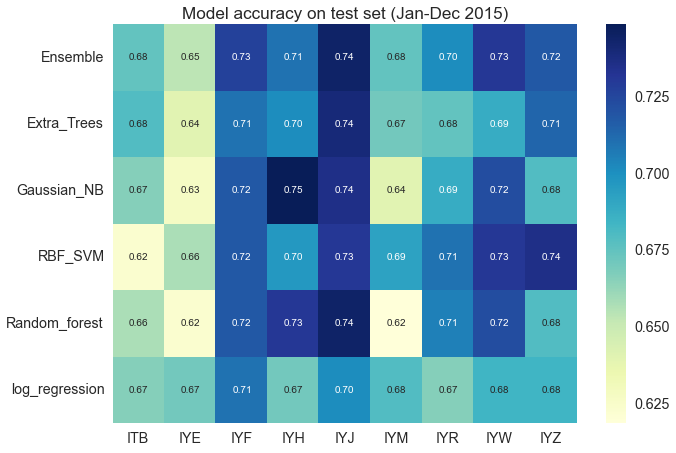

In [304]:
sns.set_context("talk", font_scale=1.1, rc={"lines.linewidth": 2.5})
ax = sns.heatmap(accuracies_df, annot=True, fmt='.2f',cmap="YlGnBu")
ax.set_title("Model accuracy on test set (Jan-Dec 2015)")

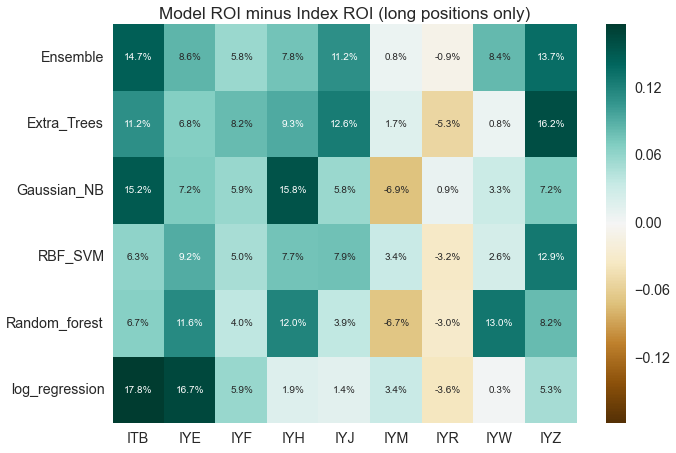

In [305]:
ax2 = sns.heatmap(ROI_diff_df, annot=True, fmt='.1%',cmap="BrBG")
ax2.set_title("Model ROI minus Index ROI (long positions only)")

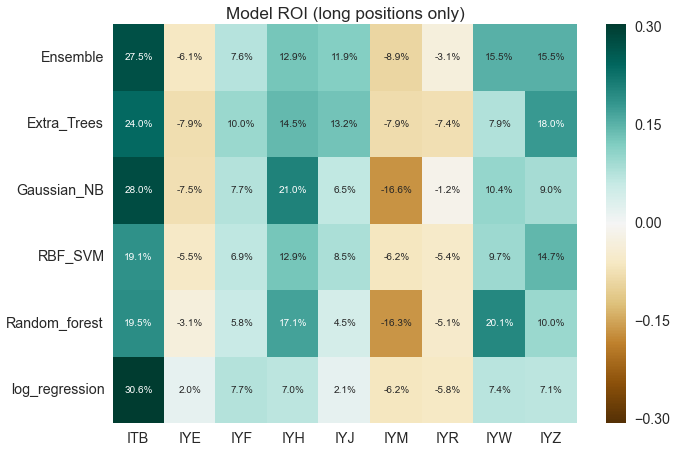

In [306]:
ax2 = sns.heatmap(ROI_all_df, annot=True, fmt='.1%',cmap="BrBG")
ax2.set_title("Model ROI (long positions only)")

In [307]:
def print_arrays_for_heatmap(aDict):
    y=0
    xcategories=[]
    ycategories=[]
    data_array=[]
    for atickr, resDict in aDict.iteritems():
        ycategories.append(atickr)
        x=0
        for aModel, value in resDict.iteritems():
            data_array.append([x,y,round(value,2)])
            x=x+1
        y=y+1
    for aModel, value in resDict.iteritems():
            xcategories.append(str(aModel))    
            
    print xcategories
    print ycategories
    print data_array
print_arrays_for_heatmap(accuracies_all)

['RBF_SVM', 'Extra_Trees', 'Gaussian_NB', 'log_regression', 'Random_forest', 'Ensemble']
['IYE', 'IYF', 'IYM', 'ITB', 'IYH', 'IYJ', 'IYW', 'IYR', 'IYZ']
[[0, 0, 0.66], [1, 0, 0.64], [2, 0, 0.63], [3, 0, 0.67], [4, 0, 0.62], [5, 0, 0.65], [0, 1, 0.72], [1, 1, 0.71], [2, 1, 0.72], [3, 1, 0.71], [4, 1, 0.72], [5, 1, 0.73], [0, 2, 0.69], [1, 2, 0.67], [2, 2, 0.64], [3, 2, 0.68], [4, 2, 0.62], [5, 2, 0.68], [0, 3, 0.62], [1, 3, 0.68], [2, 3, 0.67], [3, 3, 0.67], [4, 3, 0.66], [5, 3, 0.68], [0, 4, 0.7], [1, 4, 0.7], [2, 4, 0.75], [3, 4, 0.67], [4, 4, 0.73], [5, 4, 0.71], [0, 5, 0.73], [1, 5, 0.74], [2, 5, 0.74], [3, 5, 0.7], [4, 5, 0.74], [5, 5, 0.74], [0, 6, 0.73], [1, 6, 0.69], [2, 6, 0.72], [3, 6, 0.68], [4, 6, 0.72], [5, 6, 0.73], [0, 7, 0.71], [1, 7, 0.68], [2, 7, 0.69], [3, 7, 0.67], [4, 7, 0.71], [5, 7, 0.7], [0, 8, 0.74], [1, 8, 0.71], [2, 8, 0.68], [3, 8, 0.68], [4, 8, 0.68], [5, 8, 0.72]]
